# Heart Failure Classification Problem

## 1. Tools and Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.initializers import Zeros, RandomNormal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from math import log2

np.random.seed(42)
tf.random.set_seed(42)

## 2. Loading and Preprocessing the Dataset

#### 2.1 Loading Heart Failure Dataset

In [2]:
# Load the dataset
heart_df = pd.read_csv('heart.csv')
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [3]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


#### 2.2 Encoding Categorical Features

In [4]:
# Encode categorical features using One-Hot Encoding
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(heart_df[categorical_features])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
modified_df = pd.concat([heart_df.drop(categorical_features, axis=1), encoded_df], axis=1)

#### 2.3 Splitting Data to Training, Validation and Test Sets

In [5]:
# Split the dataset into training, validation, and test sets
X = modified_df.drop('HeartDisease', axis=1)
y = modified_df['HeartDisease']

# Split the dataset into training, validation (80%) and test (20%) sets, maintaining class distribution
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the training set into training (70%) and validation (10%) sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)

# Convert to NumPy arrays
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

print(np.sum(y_train == 1) / len(y_train))
print(np.sum(y_val == 1) / len(y_val))
print(np.sum(y_test == 1) / len(y_test))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

0.5529595015576324
0.5543478260869565
0.5543478260869565
(642, 15)
(92, 15)
(184, 15)


#### 2.4 Standardizing Features

In [6]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 3. Implementations

## 3.1 Decision Tree Classifier Implementaion

### Tree Node Class
The `Node` class represents a single node in a decision tree structure. It is used to store information about a decision point (for internal nodes) or a predicted value (for leaf nodes).

In [7]:
class Node:
  def __init__(self, left=None, right=None, info_gain=None, feature_index=None, threshold=None, value=None):
    self.left = left
    self.right = right
    self.info_gain = info_gain  # Information gain of split
    self.feature_index = feature_index  # Index of feature to split on
    self.threshold = threshold  # Threshold value to split on
    self.value = value  # Predicted value if node is leaf

### Decision Tree Classifier Class
The `DecisionTreeClassifier` class implements a basic decision tree classifier. It recursively splits the feature space based on information gain, building a binary tree structure to classify data points.

In [8]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=7, min_samples_split=10):
        """Initialize the decision tree with hyperparameters."""
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples_split = min_samples_split  # Minimum samples required to split a node
        self.root = None  # Root node of the tree, starts as None
        self.feature_index = None
        self.threshold = None
        self.sample_weight = None

    def fit(self, X, y, sample_weight = None):
        """Train the decision tree using the input features X and target y."""
        if sample_weight is None:
          self.root = self.build_tree(X, y)  # Build the tree and set the root
        else:
          self.sample_weight = sample_weight #for adaBoost decision stump
          N, d = X.shape
          min_error = float('inf')

          for feature_index in range(d):
              # Get possible thresholds for this feature
              feature_values = X[:, feature_index]
              thresholds = np.unique(feature_values)

              for threshold in thresholds:
                  # Predict using the rule: <= threshold -> -1, else +1
                  predictions = np.where(feature_values <= threshold, -1, 1)

                  # Compute weighted misclassification error
                  misclassified = (predictions != y).astype(float)
                  weighted_error = np.sum(sample_weight * misclassified)

                  # Keep track of the best (lowest error) threshold
                  if weighted_error < min_error:
                      min_error = weighted_error
                      self.feature_index = feature_index
                      self.threshold = threshold

    def predict(self, X):
        """Make predictions for each sample in X."""
        if self.sample_weight is None:
          if self.root is None:
              raise ValueError("Model has not been trained. Please call 'fit' method first.")
          # Return predictions by traversing the tree for each sample
          return [self.make_prediction(x, self.root) for x in X]
        else:
          feature_values = X[:, self.feature_index]
          # Apply the rule: <= threshold -> -1, else +1
          return np.where(feature_values <= self.threshold, -1, 1)

    def make_prediction(self, x, node):
        """Recursively traverse the tree to make a prediction for a single sample."""
        if node.value is not None:  # Leaf node reached
            return node.value
        # Decide which subtree to follow based on the feature value
        if x[node.feature_index] <= node.threshold:
            return self.make_prediction(x, node.left)
        else:
            return self.make_prediction(x, node.right)

    def print_tree(self, feature_names):
        """Print the structure of the decision tree."""
        self.print_tree_helper(self.root, 0, feature_names)  # Start from the root with depth 0

    def print_tree_helper(self, node, depth, feature_names):
        """Helper method to recursively print the tree with indentation."""
        if node is None:
            return
        indent = " " * depth  # Indentation for visual hierarchy
        if node.value is not None:  # Leaf node
            print(f"{indent}Predict: {node.value}")
        else:  # Internal node
            print(f"{indent}{feature_names[node.feature_index]} <= {node.threshold} -> True:")
            self.print_tree_helper(node.left, depth + 1, feature_names)
            print(f"{indent}{feature_names[node.feature_index]} > {node.threshold} -> False:")
            self.print_tree_helper(node.right, depth + 1, feature_names)

    def build_tree(self, X, y, depth=0):
        """Recursively build the decision tree."""
        m, n = X.shape  # Number of samples (m) and features (n)
        is_pure = len(np.unique(y)) == 1  # Check if all labels are the same

        # Base case: stop if max depth reached, data is pure, or too few samples
        if depth >= self.max_depth or is_pure or m < self.min_samples_split:
            majority_class = self.compute_output(y)  # Assign majority class to leaf
            return Node(value=majority_class)

        # Find the best split and recursively build left and right subtrees
        best_split = self.get_best_split(X, y)
        left_indices = best_split['left']
        right_indices = best_split['right']
        left_subtree = self.build_tree(X[left_indices, :], y[left_indices], depth + 1)
        right_subtree = self.build_tree(X[right_indices, :], y[right_indices], depth + 1)

        # Return a node with the split details and subtrees
        return Node(left=left_subtree,
                    right=right_subtree,
                    info_gain=best_split['info_gain'],
                    feature_index=best_split['feature_index'],
                    threshold=best_split['threshold'])

    def get_best_split(self, X, y):
        """Find the best feature and threshold to split the data."""
        _, n = X.shape
        best_split = {
            'info_gain': float('-inf'),
            'threshold': None,
            'feature_index': None,
            'left': None,
            'right': None
        }

        # Iterate over all features and their unique values as potential thresholds
        for feature_index in range(n):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                # Split data based on the threshold
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold
                left_y = y[left_indices]
                right_y = y[right_indices]

                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                # Calculate information gain for this split
                split_info_gain = self.compute_information_gain(y, left_y, right_y)

                # Update best split if this one is better
                if split_info_gain > best_split['info_gain']:
                    best_split['info_gain'] = split_info_gain
                    best_split['feature_index'] = feature_index
                    best_split['threshold'] = threshold
                    best_split['left'] = left_indices
                    best_split['right'] = right_indices

        return best_split

    def compute_output(self, y):
        """Compute the majority class for a leaf node."""
        unique_classes, frequency = np.unique(y, return_counts=True)
        majority_class = unique_classes[np.argmax(frequency)]  # Most frequent class
        # majority_count = frequency.max()
        # print(f"\nMajority Class: {majority_class} (Count: {majority_count})")
        return int(majority_class)

    def compute_entropy(self, y):
        """Calculate the entropy of a set of labels."""
        unique_classes, frequencies = np.unique(y, return_counts=True)
        n_classes = len(y)
        entropy = 0
        for frequency in frequencies:
            probability = frequency / n_classes
            entropy -= probability * log2(probability) if probability > 0 else 0
        return entropy

    def compute_information_gain(self, y, left_y, right_y):
        """Calculate information gain from a split."""
        m = len(y)
        left_m = len(left_y)
        right_m = len(right_y)

        # Entropy before and after the split
        parent_entropy = self.compute_entropy(y)
        left_entropy = self.compute_entropy(left_y) if left_m > 0 else 0
        right_entropy = self.compute_entropy(right_y) if right_m > 0 else 0

        # Weighted average of child entropies
        weighted_entropy = (left_m / m) * left_entropy + (right_m / m) * right_entropy
        information_gain = parent_entropy - weighted_entropy
        return information_gain

### Training the Decision Tree Classifier

In [9]:
# Initialize and train the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)

### Hyperparameters Tuning

In [10]:
def plot_confusion_matrix(cm):
    """Plot the confusion matrix."""
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar(label='Count')
    plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
    plt.yticks([0, 1], ['True 0', 'True 1'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [11]:
# Tune hyperparameters
max_depth_values = [2, 3, 5, 7, 9, 11, 13, 15]
min_samples_split_values = [2, 5, 10, 15, 20, 25, 30]
misclassification_rates = np.zeros((len(max_depth_values), len(min_samples_split_values)))

for i, max_depth in enumerate(max_depth_values):
    for j, min_samples_split in enumerate(min_samples_split_values):
        decision_tree_classifier = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        decision_tree_classifier.fit(X_train, y_train)
        y_pred = decision_tree_classifier.predict(X_val)
        # cm = confusion_matrix(y_val, y_pred)
        # plot_confusion_matrix(cm)
        misclassification_rates[i, j] = np.mean(y_pred != y_val)
        print(f"Misclassification Rate (Depth={max_depth}, MinSamplesSplit={min_samples_split}): {misclassification_rates[i, j]}")
    print("")

Misclassification Rate (Depth=2, MinSamplesSplit=2): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=5): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=10): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=15): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=20): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=25): 0.20652173913043478
Misclassification Rate (Depth=2, MinSamplesSplit=30): 0.20652173913043478

Misclassification Rate (Depth=3, MinSamplesSplit=2): 0.18478260869565216
Misclassification Rate (Depth=3, MinSamplesSplit=5): 0.18478260869565216
Misclassification Rate (Depth=3, MinSamplesSplit=10): 0.18478260869565216
Misclassification Rate (Depth=3, MinSamplesSplit=15): 0.18478260869565216
Misclassification Rate (Depth=3, MinSamplesSplit=20): 0.18478260869565216
Misclassification Rate (Depth=3, MinSamplesSplit=25): 0.18478260869565216
Misclassification Rate (Depth=3, MinSampl

### Training the Final Model with Optimal Hyperparameters

Best Max Depth: 3
Best Min Samples Split: 2
Misclassification Rate: 0.24456521739130435
Accuracy: 0.7554347826086957
F1-Score: 0.789


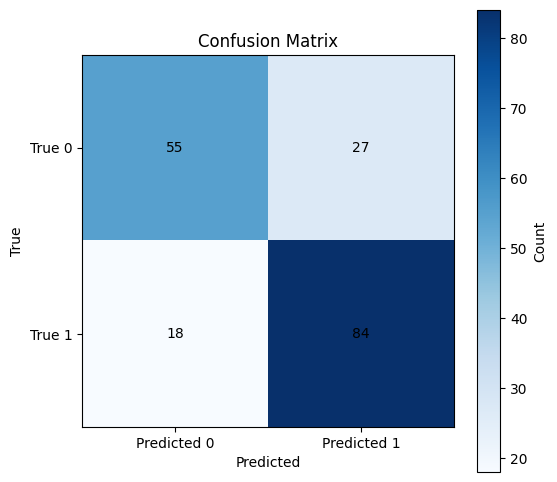

ST_Slope_Up <= 0.0 -> True:
 MaxHR <= 142.0 -> True:
  Sex_M <= 0.0 -> True:
   Predict: 1
  Sex_M > 0.0 -> False:
   Predict: 1
 MaxHR > 142.0 -> False:
  Cholesterol <= 190.0 -> True:
   Predict: 1
  Cholesterol > 190.0 -> False:
   Predict: 1
ST_Slope_Up > 0.0 -> False:
 Oldpeak <= 0.4 -> True:
  Age <= 55.0 -> True:
   Predict: 0
  Age > 55.0 -> False:
   Predict: 0
 Oldpeak > 0.4 -> False:
  MaxHR <= 132.0 -> True:
   Predict: 1
  MaxHR > 132.0 -> False:
   Predict: 0


In [12]:
# Find the best hyperparameters
best_idx = np.unravel_index(np.argmin(misclassification_rates, axis=None), misclassification_rates.shape)
best_max_depth = max_depth_values[best_idx[0]]
best_min_samples_split = min_samples_split_values[best_idx[1]]
print(f"Best Max Depth: {best_max_depth}")
print(f"Best Min Samples Split: {best_min_samples_split}")

# Intialize and train the Decision Tree Classifier with the best hyperparameters
decision_tree_classifier = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
decision_tree_classifier.fit(X_train, y_train)

# Make predictions and evaluate the model on the test set
y_pred = decision_tree_classifier.predict(X_test)

# Calculate the misclassification rate, accuracy, F1-score, and confusion matrix
misclassification_rate = np.mean(y_pred != y_test)
print(f"Misclassification Rate: {misclassification_rate}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.3f}")

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

# Print the structure of the decision tree
decision_tree_classifier.print_tree(feature_names=X.columns)

## 3.2 Bagging Ensemble

## 3.3 AdaBoost Ensemble

### AdaBoost Classifier Class

In [13]:
class AdaBoostClassifier:
    def __init__(self, T=50):
        """Initialize AdaBoost with the number of iterations T."""
        self.T = T
        self.h_t = []      # List to store weak learners
        self.alpha_t = []  # Their corresponding weights

    def fit(self, X, y):
        """Train the AdaBoost classifier using input features X and labels y."""
        N = X.shape[0]  # Number of samples
        self.w = np.full(N, 1 / N)  # Initialize weights uniformly

        # Ensure labels are -1 and 1 for correct weight updates
        y = np.where(y == 0, -1, 1)

        for t in range(self.T):
            # Train a weak learner with weighted samples
            ht = DecisionTreeClassifier(max_depth=1)  # Decision stump
            ht.fit(X, y, sample_weight=self.w)  # Pass weights into fit

            # Get predictions
            y_pred = ht.predict(X)

            # Compute weighted error
            incorrect = (y_pred != y).astype(int)
            errt = np.sum(self.w * incorrect) / np.sum(self.w)

            # Avoid division by zero
            errt = max(errt, 1e-10)
            alpha_t = 0.5 * np.log((1 - errt) / errt)

            # Update sample weights
            self.w *= np.exp(2 * alpha_t * incorrect)
            self.w /= np.sum(self.w)  # Normalize

            # Save weak learner and weight
            self.h_t.append(ht)
            self.alpha_t.append(alpha_t)

    def predict(self, X):
        """Make predictions for each sample in X"""
        # Get predictions from all weak learners
        y_preds = np.asarray([ht.predict(X) for ht in self.h_t])  # Shape: (T, N)
        alpha_t = np.array(self.alpha_t).reshape(len(self.alpha_t), 1)

        # Compute final prediction H(x) and convert back to {0,1}
        preds = np.sign(y_preds.T @ alpha_t).flatten()
        return np.where(preds == -1, 0, 1)

### Training the AdaBoost Classifier

In [14]:
ada_boost_classifier = AdaBoostClassifier()
ada_boost_classifier.fit(X_train, y_train)

### Hyperparameters tuning

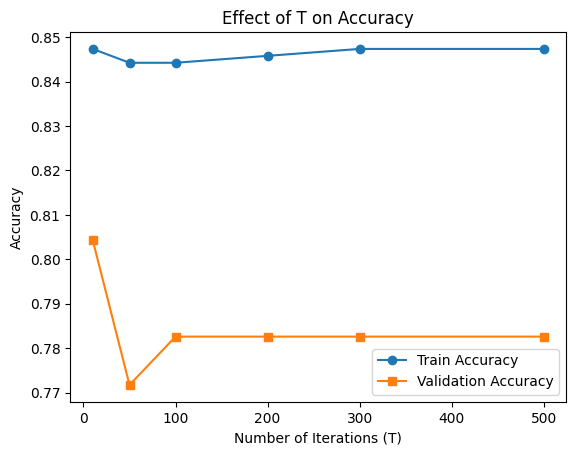

In [15]:
T_values = [10, 50, 100, 200, 300, 500]
train_acc = []
val_acc = []

for T in T_values:
    model = AdaBoostClassifier(T=T)
    model.fit(X_train, y_train)

    # Evaluate accuracy
    train_acc.append(accuracy_score(y_train, model.predict(X_train)))
    val_acc.append(accuracy_score(y_val, model.predict(X_val)))  # Use validation set

# Plot results
plt.plot(T_values, train_acc, label="Train Accuracy", marker="o")
plt.plot(T_values, val_acc, label="Validation Accuracy", marker="s")
plt.xlabel("Number of Iterations (T)")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Effect of T on Accuracy")
plt.show()

### Training the Final Model with the Optimal Hyperparameters

Best T: 10, Best Validation Accuracy: 0.8043
Misclassification Rate:  0.163
Accuracy:  0.837
F1-Score: 0.845


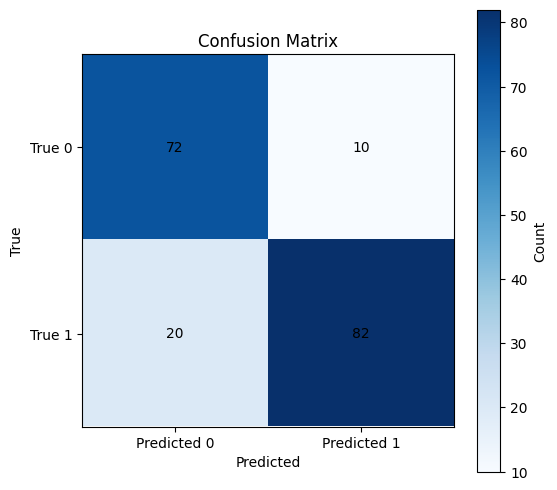

In [16]:
# Find the best hyperparameters
best_T = T_values[np.argmax(val_acc)]
print(f"Best T: {best_T}, Best Validation Accuracy: {max(val_acc):.4f}")

# Intialize and train the AdaBoost Classifier with the best hyperparameters
ada_boost_classifier = AdaBoostClassifier(T = best_T)
ada_boost_classifier.fit(X_train, y_train)

# Make predictions and evaluate the model on the test set
y_pred = ada_boost_classifier.predict(X_test)

# Calculate the misclassification rate, accuracy, F1-score, and confusion matrix
misclassification_rate = np.mean(y_pred != y_test)
print(f"Misclassification Rate: {misclassification_rate: .3f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy: .3f}")

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.3f}")

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

# 4. Bonus

## 4.1 K-Nearest Neighbors (KNN) Classifier

### Training the KNN model

In [17]:
k_values = [3, 5, 7, 11, 15, 21]
val_acc = []

# Train KNN for different values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)  # Train model

    # Predict on validation set
    y_val_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)  # Compute accuracy
    val_acc.append(acc)

### Selecting Best Performing K

Best k: 5, Best Validation Accuracy: 0.7283
Test Accuracy with k=5: 0.7065


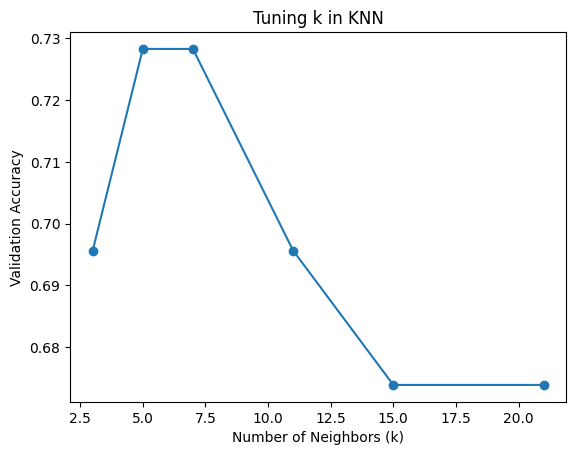

In [18]:
# Find the best k
best_k = k_values[np.argmax(val_acc)]
print(f"Best k: {best_k}, Best Validation Accuracy: {max(val_acc):.4f}")

# Train final model with best k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

# Evaluate on test set
y_test_pred = best_knn.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with k={best_k}: {test_acc:.4f}")

# Plot validation accuracy vs. k
plt.plot(k_values, val_acc, marker="o", linestyle="-")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy")
plt.title("Tuning k in KNN")
plt.show()

## 4.2 Logistic Regression

## 4.3 Feedforward Neural Network (FNN) with Keras

### Building the Neural Network Model

In [19]:
# Initialize the neural network
network = models.Sequential()

# Add the hidden layer with ReLU activation function
network.add(layers.Dense(16, activation='relu', input_shape=(X.shape[1],)))

# Add the output layer with sigmoid activation function
network.add(layers.Dense(1, activation='sigmoid'))

# Add SGD optimizer with learning rate 0.01
optimizer = optimizers.SGD(learning_rate=0.01)

# Compile the network with binary cross-entropy loss function
network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the network
history = network.fit(X_train_scaled,
                      y_train,
                      epochs=50,
                      verbose=1)

# print("Weights after training: ", network.get_weights())

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3094 - loss: 0.8870  
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4087 - loss: 0.7876 
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5327 - loss: 0.7138 
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6226 - loss: 0.6565 
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6842 - loss: 0.6107 
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7209 - loss: 0.5731 
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7543 - loss: 0.5413 
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7900 - loss: 0.5143 
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8110 - loss: 0.4912 
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8277 - loss: 0.4710 
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8361 - loss: 0.4533 
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8317 - l

### Hyperparameters Tuning

In [20]:
# Tuning the hyperparameters
learning_rates = [0.001, 0.01, 0.1]
hidden_units = [8, 16, 32]
epochs = [50, 100, 200, 500]

best_accuracy = 0
best_hyperparameters = None

for lr in learning_rates:
    for n_neurons in hidden_units:
        for n_epochs in epochs:
            network = models.Sequential()
            network.add(layers.Dense(n_neurons, 
                                     activation='relu', 
                                     input_shape=(X.shape[1],), 
                                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05),
                                     bias_initializer=Zeros()))
            
            network.add(layers.Dense(1, 
                                     activation='sigmoid',
                                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.05),
                                     bias_initializer=Zeros()))
            optimizer = optimizers.SGD(learning_rate=lr)
            network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            # Early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
            history = network.fit(X_train_scaled,
                                    y_train,
                                    epochs=n_epochs,
                                    verbose=0,
                                    callbacks=[early_stopping],
                                    validation_data=(X_val_scaled, y_val))
            val_loss, val_accuracy = network.evaluate(X_val_scaled, y_val, verbose=0)
            print(f'lr={lr}, n_neurons={n_neurons}, n_epochs={n_epochs}, val_accuracy={val_accuracy}')
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_hyperparameters = (lr, n_neurons, n_epochs)

print(f"Best hyperparameters: lr={best_hyperparameters[0]}, n_neurons={best_hyperparameters[1]}, n_epochs={best_hyperparameters[2]}")

lr=0.001, n_neurons=8, n_epochs=50, val_accuracy=0.554347813129425
lr=0.001, n_neurons=8, n_epochs=100, val_accuracy=0.717391312122345
lr=0.001, n_neurons=8, n_epochs=200, val_accuracy=0.8260869383811951
lr=0.001, n_neurons=8, n_epochs=500, val_accuracy=0.804347813129425
lr=0.001, n_neurons=16, n_epochs=50, val_accuracy=0.5652173757553101
lr=0.001, n_neurons=16, n_epochs=100, val_accuracy=0.79347825050354
lr=0.001, n_neurons=16, n_epochs=200, val_accuracy=0.79347825050354
lr=0.001, n_neurons=16, n_epochs=500, val_accuracy=0.782608687877655
lr=0.001, n_neurons=32, n_epochs=50, val_accuracy=0.6086956262588501
lr=0.001, n_neurons=32, n_epochs=100, val_accuracy=0.8260869383811951
lr=0.001, n_neurons=32, n_epochs=200, val_accuracy=0.79347825050354
lr=0.001, n_neurons=32, n_epochs=500, val_accuracy=0.79347825050354
lr=0.01, n_neurons=8, n_epochs=50, val_accuracy=0.782608687877655
lr=0.01, n_neurons=8, n_epochs=100, val_accuracy=0.782608687877655
lr=0.01, n_neurons=8, n_epochs=200, val_accura

### Training the Final Model with Optimal Hyperparameters

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5788 - loss: 0.6863 - val_accuracy: 0.7065 - val_loss: 0.6665
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7355 - loss: 0.6472 - val_accuracy: 0.8043 - val_loss: 0.5993
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8731 - loss: 0.5480 - val_accuracy: 0.7826 - val_loss: 0.4911
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8720 - loss: 0.4137 - val_accuracy: 0.7826 - val_loss: 0.4416
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8793 - loss: 0.3434 - val_accuracy: 0.7826 - val_loss: 0.4338
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8868 - loss: 0.3184 - val_accuracy: 0.7826 - val_loss: 0.4316
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8856 - loss: 0.3076 - val_accuracy: 0.7826 - val_loss: 0.4279
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8896 - loss: 0.3011 - val_accuracy: 0.7826 - val_loss: 0.4

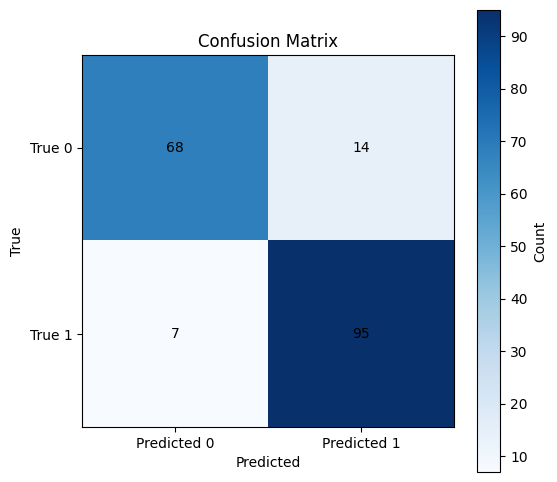

F1 score: 0.9005


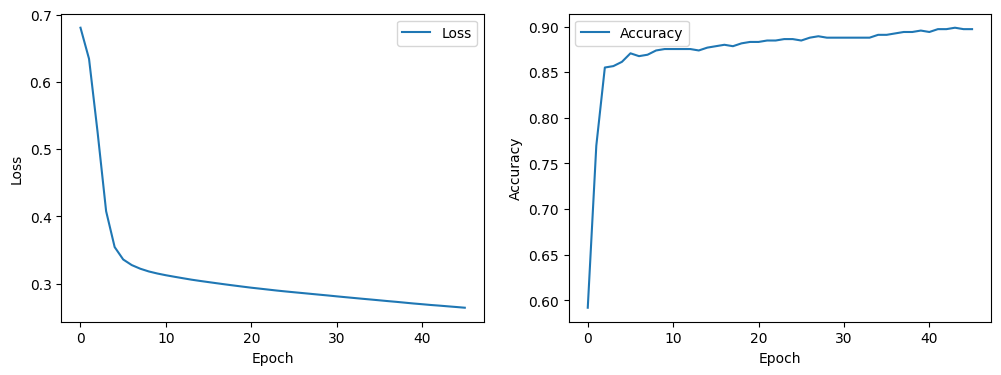

In [22]:
# Initialize the neural network
network = models.Sequential()

# Add the hidden layer with ReLU activation function
network.add(layers.Dense(best_hyperparameters[1], 
                         activation='relu', input_shape=(X.shape[1],),
                         kernel_initializer=RandomNormal(mean=0.0, stddev=0.05),
                         bias_initializer=Zeros()))

# Add the output layer with sigmoid activation function
network.add(layers.Dense(1, 
                         activation='sigmoid',
                         kernel_initializer=RandomNormal(mean=0.0, stddev=0.05),
                         bias_initializer=Zeros()))

# Add SGD optimizer with learning rate 0.01
optimizer = optimizers.SGD(learning_rate=best_hyperparameters[0])

# Compile the network with binary cross-entropy loss function
network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the network
history = network.fit(X_train_scaled,
                      y_train,
                      epochs=best_hyperparameters[2],
                      verbose=1,
                      callbacks=[early_stopping],
                      validation_data=(X_val_scaled, y_val))

# Evaluate the network
# print("Weights after training: ", network.get_weights())
test_loss, test_accuracy = network.evaluate(X_test_scaled, y_test)
print(f'Test loss after tuning: {test_loss}')
print(f'Test accuracy after tuning: {test_accuracy}')

y_pred_prob = network.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

f1 = f1_score(y_test, y_pred)
print(f"F1 score: {f1:.4f}")

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()